In [ ]:
!pip install scikit-optimize

In [ ]:
import sys
pasta_projeto = '/content/drive/My Drive/ColabNotebooks/Projetos Portifolio/Airbnb Open Data'
sys.path.append(pasta_projeto)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import log_loss,accuracy_score,mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from skopt import forest_minimize
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

import joblib as jb

from utils import Utils

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline
%pylab inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
pasta_dados = pasta_projeto+'/data'

In [ ]:
dados = pd.read_csv(pasta_dados+'/dados_final.csv', index_col=0)
dados.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,Entire home/apt,Hotel room,Private room,Shared room,neighbourhood_labels
id,,,,,,,,,,,
21280,442,5,94,1.23,90,1,1,0,0,0,9
48726,105,3,42,1.35,90,1,0,0,1,0,3
48901,548,4,4,0.07,348,1,1,0,0,0,3
50294,1206,3,72,0.67,322,5,1,0,0,0,9
60718,1084,7,8,0.07,240,2,1,0,0,0,3


In [ ]:
dados.dtypes

price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
availability_365                    int64
calculated_host_listings_count      int64
Entire home/apt                     int64
Hotel room                          int64
Private room                        int64
Shared room                         int64
neighbourhood_labels                int64
dtype: object

In [ ]:
dados._get_numeric_data().describe()[1:]

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,Entire home/apt,Hotel room,Private room,Shared room,neighbourhood_labels
mean,416.623642,3.609459,7.602607,0.319503,168.019728,2.689964,0.690633,0.004653,0.280651,0.024062,4.929853
std,387.715722,4.279613,15.851824,0.581797,154.543320,3.939019,0.462240,0.068056,0.449325,0.153245,2.366210
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,149.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,277.000000,2.000000,1.000000,0.070000,143.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000
75%,525.000000,4.000000,6.000000,0.360000,362.000000,2.000000,1.000000,0.000000,1.000000,0.000000,6.000000
max,2000.000000,30.000000,100.000000,8.490000,365.000000,30.000000,1.000000,1.000000,1.000000,1.000000,9.000000


In [ ]:
scaler = jb.load(pasta_projeto+'/minmax_dados.pkl.z')
with open(pasta_projeto+'/columns.npy', 'rb') as f:
    columns = np.load(f)
f.close()
transform = scaler.transform(dados[columns])

In [ ]:
scaler_price = MinMaxScaler(feature_range=(0,1))
columns_price = ['price']
price_new = scaler.fit(dados[columns_price])
transform_price = price_new.transform(dados[columns_price])

In [ ]:
dados_n = pd.concat([pd.DataFrame(transform, index=dados.index, columns=columns), pd.DataFrame(transform_price, index=dados.index, columns=['price']), dados[['neighbourhood_labels']]], axis=1)
dados_n.head()

,minimum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,Entire home/apt,Hotel room,Private room,Shared room,price,neighbourhood_labels
id,,,,,,,,,,,
21280,0.137931,0.94,0.144876,0.246575,0.000000,1.0,0.0,0.0,0.0,0.2210,9
48726,0.068966,0.42,0.159011,0.246575,0.000000,0.0,0.0,1.0,0.0,0.0525,3
48901,0.103448,0.04,0.008245,0.953425,0.000000,1.0,0.0,0.0,0.0,0.2740,3
50294,0.068966,0.72,0.078916,0.882192,0.137931,1.0,0.0,0.0,0.0,0.6030,9
60718,0.206897,0.08,0.008245,0.657534,0.034483,1.0,0.0,0.0,0.0,0.5420,3


In [ ]:
with open(pasta_dados+'/train.npy', 'rb') as f:
    train = np.load(f)
f.close()
with open(pasta_dados+'/valid.npy', 'rb') as f:
    valid = np.load(f)
f.close()

In [ ]:
train = dados_n.iloc[train]
valid = dados_n.iloc[valid]

In [ ]:
train.head()

,minimum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,Entire home/apt,Hotel room,Private room,Shared room,price,neighbourhood_labels
id,,,,,,,,,,,
10757209,0.000000,0.00,0.000000,1.000000,0.000000,1.0,0.0,0.0,0.0,0.9620,6
13798162,0.310345,0.00,0.000000,1.000000,0.172414,1.0,0.0,0.0,0.0,0.4995,6
42717550,0.068966,0.00,0.000000,0.997260,0.137931,1.0,0.0,0.0,0.0,0.2985,3
32060355,0.034483,0.01,0.037691,0.246575,0.000000,0.0,0.0,1.0,0.0,0.0385,3
22541482,1.000000,0.00,0.000000,1.000000,0.034483,0.0,0.0,1.0,0.0,0.0575,9


In [ ]:
X_train, y_train = train.drop('price', axis=1), train['price']
X_valid, y_valid = valid.drop('price', axis=1), valid['price']

In [ ]:
model = DecisionTreeRegressor(random_state=0, max_depth=int(dados.shape[0]))#, class_weight="balanced")
model.fit(X_train, y_train)
predict_dt = model.predict(X_valid)
np.sqrt(mean_squared_log_error(y_valid.values, predict_dt))

0.11293569221219761

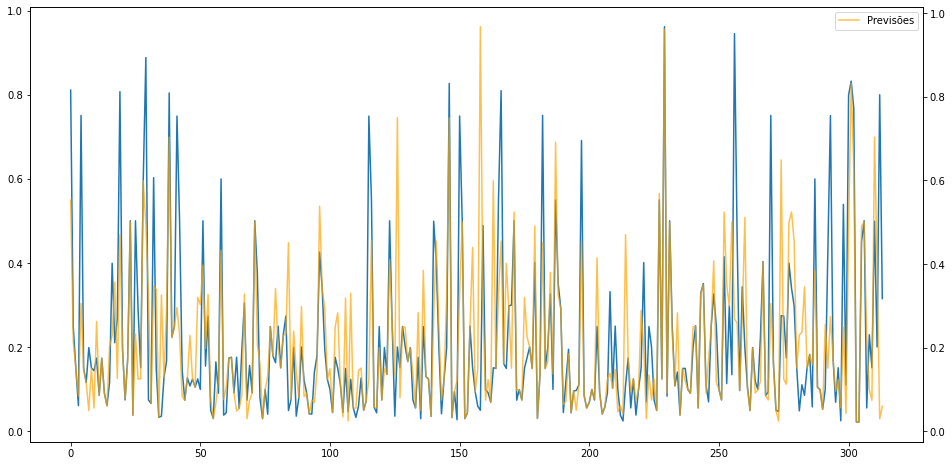

In [ ]:
fig, ax = pylab.subplots(1, 1, figsize = (16, 8))
ax.plot(y_valid.values, label='Y')
axt = ax.twinx()
axt.plot(predict_dt, color='orange', alpha=0.7, label='Previsões')
axt.legend()

In [ ]:
model = RandomForestRegressor(random_state=0,
                              n_estimators=300,
                              n_jobs=-1)

model.fit(X_train, y_train)
predict_rf = model.predict(X_valid)
np.sqrt(mean_squared_log_error(y_valid.values, predict_rf))

0.09811859316625825

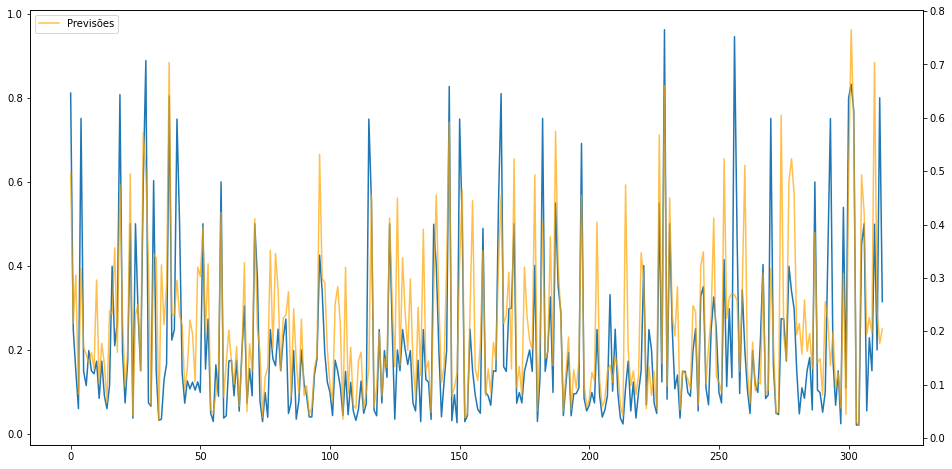

In [ ]:
fig, ax = pylab.subplots(1, 1, figsize = (16, 8))
ax.plot(y_valid.values, label='Y')
axt = ax.twinx()
axt.plot(predict_rf, color='orange', alpha=0.7, label='Previsões')
axt.legend()

In [ ]:
model = LGBMRegressor(n_jobs=-1, 
                      random_state=0, 
                      n_estimators=10000, 
                      learning_rate=0.5, 
                      num_leaves=2**8,  
                      subsample_freq=1)
model.fit(X_train, y_train)
predict_l = model.predict(X_valid)

predict_l = abs(predict_l)
np.sqrt(mean_squared_log_error(y_valid.values, predict_l))

0.1008008638486307

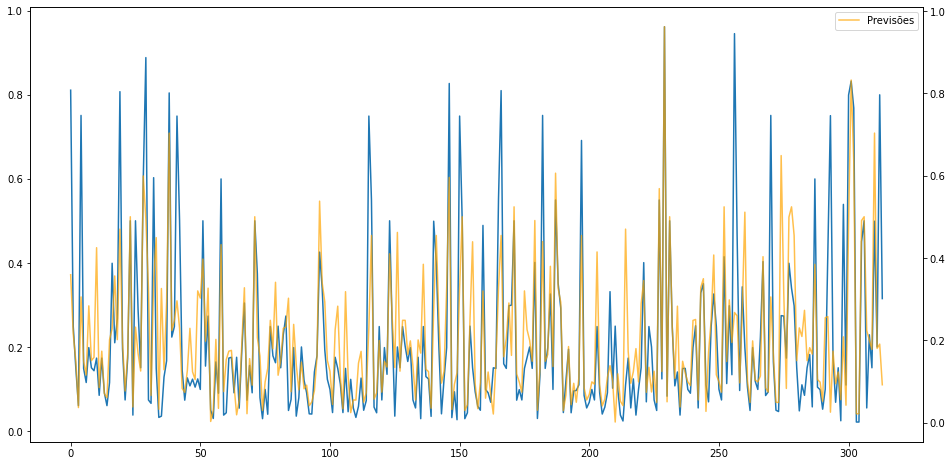

In [ ]:
fig, ax = pylab.subplots(1, 1, figsize = (16, 8))
ax.plot(y_valid.values, label='Y')
axt = ax.twinx()
axt.plot(predict_l, color='orange', alpha=0.7, label='Previsões')
axt.legend()

In [ ]:
jb.dump(model, pasta_projeto+"/modelo_rf.pkl.z")
jb.dump(price_new, pasta_projeto+"/minmax_price.pkl.z")

['/content/drive/My Drive/ColabNotebooks/Projetos Portifolio/Airbnb Open Data/minmax_price.pkl.z']